In [3]:
# imports

import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

# Pfad zum Datensatz
base_path = Path(r"/Users/mkruse/Documents/repos/FabriCAD/data/1_raw")

In [4]:
folders = [f for f in base_path.iterdir() if f.is_dir()]
complete_folders = []
incomplete_folders = []

for folder in tqdm(folders, desc="Überprüfe Ordner"):
    folder_number = folder.name
    geometry_file = folder / f"geometry_{folder_number}.step"
    
    if geometry_file.exists():
        complete_folders.append(folder)
    else:
        incomplete_folders.append(folder)

print(f"{'='*60}")
print(f"Vollständige Ordner (mit geometry.step): {len(complete_folders)}")
print(f"Unvollständige Ordner (ohne geometry.step): {len(incomplete_folders)}")
print(f"Vollständigkeit: {len(complete_folders)/len(folders)*100:.2f}%")

#  unvollständige Ordner anzeigen
if incomplete_folders:
    print(f"\nErste unvollständige Ordner:")
    for folder in incomplete_folders[:10]:
        print(f"  - {folder.name}")

Überprüfe Ordner: 100%|██████████| 100000/100000 [00:04<00:00, 24669.32it/s]

Vollständige Ordner (mit geometry.step): 14426
Unvollständige Ordner (ohne geometry.step): 85574
Vollständigkeit: 14.43%

Erste unvollständige Ordner:
  - 00033216
  - 00063566
  - 00082854
  - 00057753
  - 00056681
  - 00083986
  - 00025373
  - 00075403
  - 00094931
  - 00041636


In [22]:
all_steps = []
all_data = []
plan_stats = []
step_volume_changes = []
step_costs = []
plan_total_costs = []
step_counts_per_plan = []
all_workplaces = []
all_qualifications = []

for folder in tqdm(folders, desc="Lese alle Daten aus plan.csv"):
    plan_file = folder / "plan.csv"
    
    if plan_file.exists():
        try:
            df = pd.read_csv(plan_file, sep=';')
            
            # Ausgangsvolumen bei Nr. == 0
            init_volume = df[df['Nr.'] == 0]['Volumen[mm^3]'].iloc[0] if len(df[df['Nr.'] == 0]) > 0 else None
            
            # Nur echte Arbeitsschritte (Nr. >= 1)
            df_steps = df[df['Nr.'] >= 1].copy()
            
            if len(df_steps) > 0 and init_volume is not None:
                # 1. Schritt-Namen für Häufigkeit
                all_steps.extend(df_steps['Schritt'].tolist())
                
                # 2. Detail-Daten für spätere Analysen
                all_data.append(df_steps[['Schritt', 'Volumen[mm^3]', 'Kosten[($)]', 'Dauer[min]']])
                
                # 3. Plan-Statistiken
                end_volume = df_steps['Volumen[mm^3]'].iloc[-1]
                volume_diff = end_volume - init_volume
                avg_cost = df_steps['Kosten[($)]'].mean()
                avg_duration = df_steps['Dauer[min]'].mean()
                total_cost = df_steps['Kosten[($)]'].sum()
                
                plan_stats.append({
                    'Ordner': folder.name,
                    'Ausgangsvolumen': init_volume,
                    'Endvolumen': end_volume,
                    'Volumendifferenz': volume_diff,
                    'Avg_Kosten': avg_cost,
                    'Avg_Dauer': avg_duration,
                    'Gesamtkosten': total_cost,
                    'Anzahl_Schritte': len(df_steps)
                })
                
                # 4. Volumenänderung pro Schritt
                df_steps['Volumen_vorher'] = df['Volumen[mm^3]'].shift(1)
                df_steps['Vol_Diff'] = df_steps['Volumen[mm^3]'] - df_steps['Volumen_vorher']
                
                for _, row in df_steps.iterrows():
                    step_volume_changes.append({
                        'Schritt': row['Schritt'],
                        'Volumendifferenz': row['Vol_Diff']
                    })
                    
                    # 5. Kosten pro Schritt
                    step_costs.append({
                        'Schritt': row['Schritt'],
                        'Kosten': row['Kosten[($)]']
                    })
                    
                    # 6. Arbeitsplätze
                    all_workplaces.append(row['Arbeitsplatz'])
                    
                    # 7. Qualifikationen
                    all_qualifications.append(row['Qualifikation'])
                
                # 8. Gesamtkosten pro Plan
                plan_total_costs.append(total_cost)
                
                # 9. Anzahl Schritte pro Plan
                step_counts_per_plan.append(len(df_steps))
                
        except Exception as e:
            print(f"Fehler in {folder.name}: {e}")

# DataFrames erstellen
data_df = pd.concat(all_data, ignore_index=True)
plan_stats_df = pd.DataFrame(plan_stats)
step_vol_df = pd.DataFrame(step_volume_changes)
step_costs_df = pd.DataFrame(step_costs)
plan_costs_df = pd.DataFrame({'Gesamtkosten': plan_total_costs})
step_counts_df = pd.DataFrame({'Anzahl_Schritte': step_counts_per_plan})

step_counts = Counter(all_steps)
step_df = pd.DataFrame(step_counts.items(), columns=['Schritt', 'Häufigkeit'])
step_df = step_df.sort_values('Häufigkeit', ascending=False)

avg_duration_per_step = data_df.groupby('Schritt')['Dauer[min]'].mean().reset_index()
avg_duration_per_step.columns = ['Schritt', 'Avg_Dauer']
avg_duration_per_step = avg_duration_per_step.sort_values('Avg_Dauer', ascending=True)


print(f"\n{'='*60}")
print(f"Erfolgreich eingelesen:")
print(f"  - {len(all_steps)} Arbeitsschritte insgesamt")
print(f"  - {len(plan_stats_df)} vollständige Pläne")
print(f"  - {len(step_vol_df)} Volumenänderungen")
print(f"  - {len(step_costs_df)} Kosten-Einträge")
print(f"  - {len(all_workplaces)} Arbeitsplatz-Zuweisungen")
print(f"  - {len(all_qualifications)} Qualifikations-Anforderungen")
print(f"{'='*60}")

Lese alle Daten aus plan.csv: 100%|██████████| 100000/100000 [04:12<00:00, 396.66it/s]



Erfolgreich eingelesen:
  - 359511 Arbeitsschritte insgesamt
  - 99994 vollständige Pläne
  - 359511 Volumenänderungen
  - 359511 Kosten-Einträge
  - 359511 Arbeitsplatz-Zuweisungen
  - 359511 Qualifikations-Anforderungen


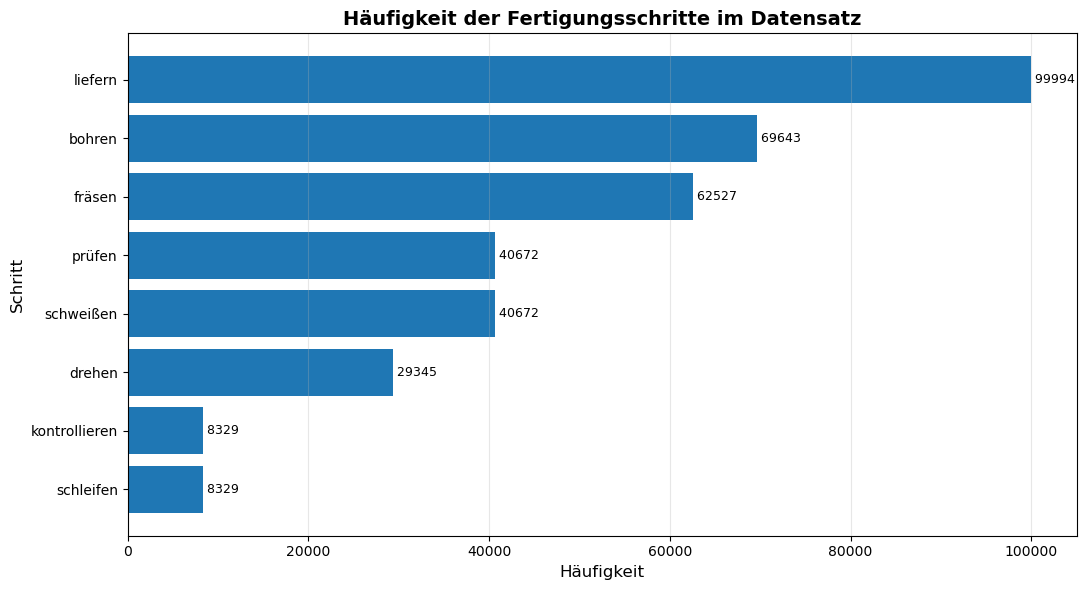

In [23]:
# Häufigkeit Fertigungsschritte
plot_df = step_df.sort_values('Häufigkeit', ascending=True)

fig, ax = plt.subplots(figsize=(11.0, max(6, len(plot_df) * 0.3)))

bars = ax.barh(plot_df['Schritt'], plot_df['Häufigkeit'])

for i, (schritt, count) in enumerate(zip(plot_df['Schritt'], plot_df['Häufigkeit'])):
    ax.text(count, i, f' {count}', va='center', fontsize=9)

ax.set_xlabel('Häufigkeit', fontsize=12)
ax.set_ylabel('Schritt', fontsize=12)
ax.set_title('Häufigkeit der Fertigungsschritte im Datensatz', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

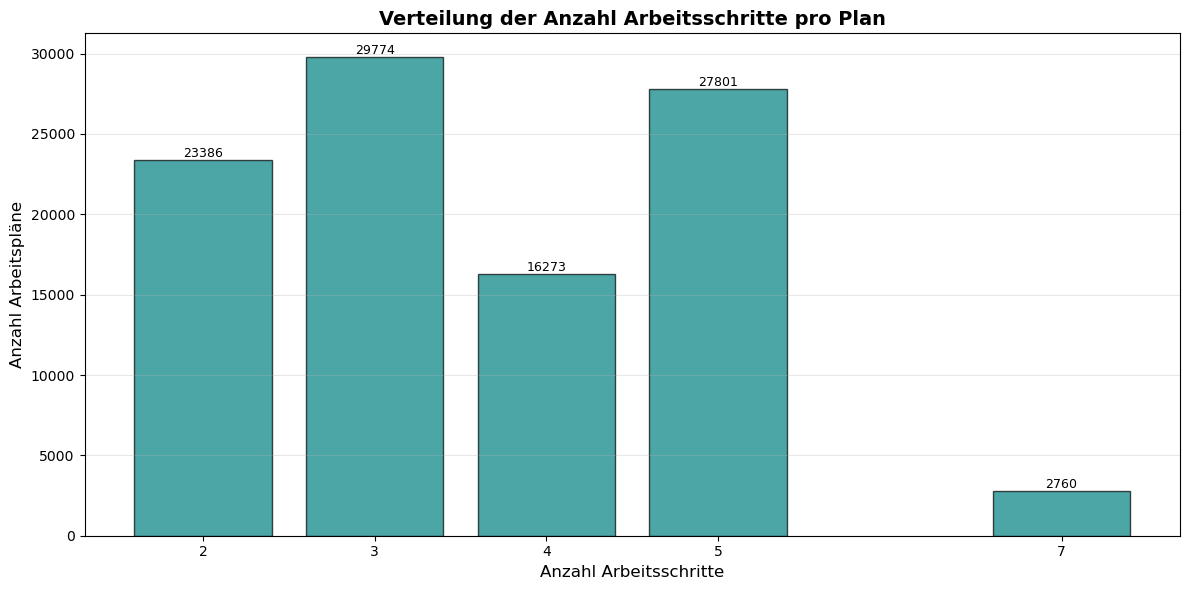

In [24]:
#  Verteilung der Schrittanzahl
step_distribution = step_counts_df['Anzahl_Schritte'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(step_distribution.index, step_distribution.values, 
              edgecolor='black', alpha=0.7, color='teal')

for i, (steps, count) in enumerate(zip(step_distribution.index, step_distribution.values)):
    ax.text(steps, count, f'{int(count)}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Anzahl Arbeitsschritte', fontsize=12)
ax.set_ylabel('Anzahl Arbeitspläne', fontsize=12)
ax.set_title('Verteilung der Anzahl Arbeitsschritte pro Plan', fontsize=14, fontweight='bold')
ax.set_xticks(step_distribution.index)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

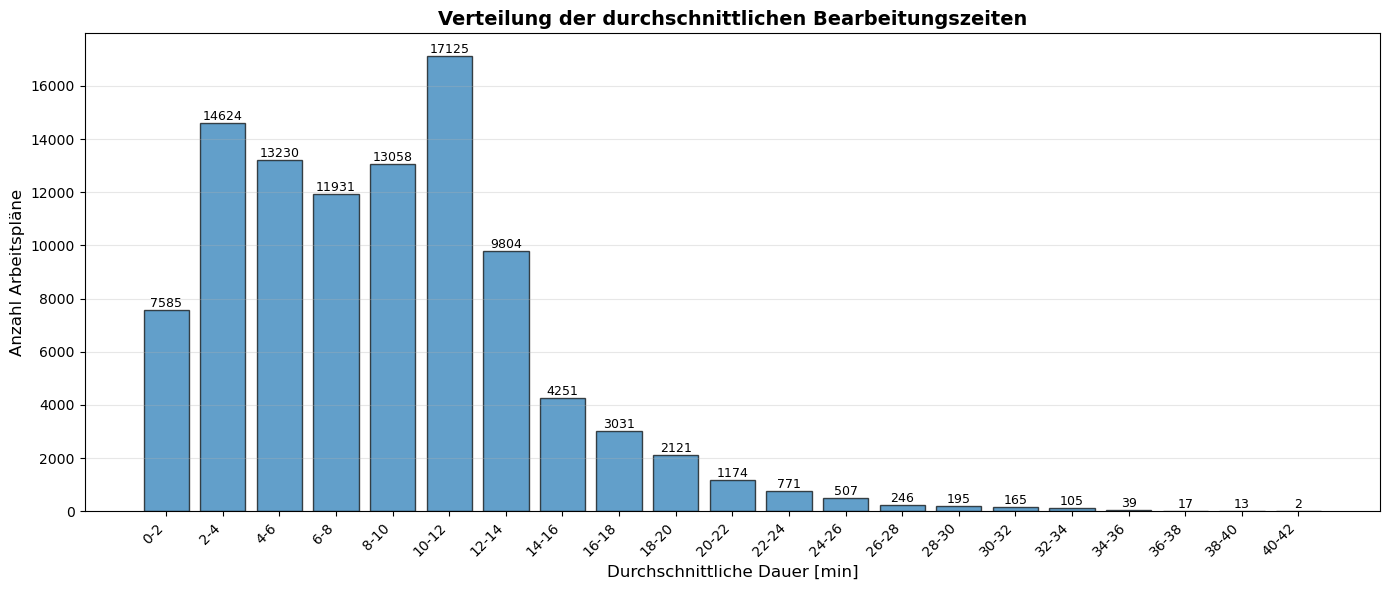

Minimale Dauer: 0.00 min
Maximale Dauer: 40.15 min


In [25]:
# Bearbeitungszeiten
import numpy as np

bins = np.arange(0, plan_stats_df['Avg_Dauer'].max() + 2, 2)

counts, bin_edges = np.histogram(plan_stats_df['Avg_Dauer'], bins=bins)

bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(bin_labels, counts, edgecolor='black', alpha=0.7)

for i, (bar, count) in enumerate(zip(bars, counts)):
    if count > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{int(count)}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Durchschnittliche Dauer [min]', fontsize=12)
ax.set_ylabel('Anzahl Arbeitspläne', fontsize=12)
ax.set_title('Verteilung der durchschnittlichen Bearbeitungszeiten', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Minimale Dauer: {plan_stats_df['Avg_Dauer'].min():.2f} min")
print(f"Maximale Dauer: {plan_stats_df['Avg_Dauer'].max():.2f} min")

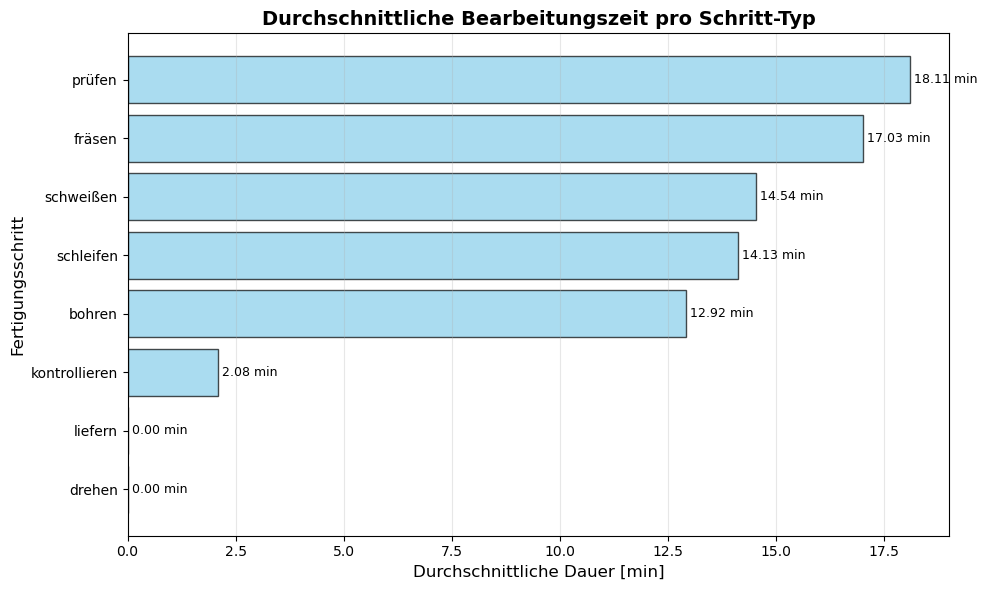


Top 5 zeitintensivste Schritte:
  Schritt  Avg_Dauer
   prüfen  18.111231
   fräsen  17.026831
schweißen  14.541128
schleifen  14.126912
   bohren  12.921951

Top 5 schnellste Schritte:
      Schritt  Avg_Dauer
       drehen   0.000000
      liefern   0.000000
kontrollieren   2.082003
       bohren  12.921951
    schleifen  14.126912


In [26]:
#  Durchschnittliche Bearbeitungszeit pro Schritt
fig, ax = plt.subplots(figsize=(10, max(6, len(avg_duration_per_step) * 0.3)))

bars = ax.barh(avg_duration_per_step['Schritt'], avg_duration_per_step['Avg_Dauer'], 
               color='skyblue', alpha=0.7, edgecolor='black')

for i, (schritt, dauer) in enumerate(zip(avg_duration_per_step['Schritt'], avg_duration_per_step['Avg_Dauer'])):
    ax.text(dauer, i, f' {dauer:.2f} min', va='center', fontsize=9)

ax.set_xlabel('Durchschnittliche Dauer [min]', fontsize=12)
ax.set_ylabel('Fertigungsschritt', fontsize=12)
ax.set_title('Durchschnittliche Bearbeitungszeit pro Schritt-Typ', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 zeitintensivste Schritte:")
print(avg_duration_per_step.nlargest(5, 'Avg_Dauer')[['Schritt', 'Avg_Dauer']].to_string(index=False))

print("\nTop 5 schnellste Schritte:")
print(avg_duration_per_step.nsmallest(5, 'Avg_Dauer')[['Schritt', 'Avg_Dauer']].to_string(index=False))

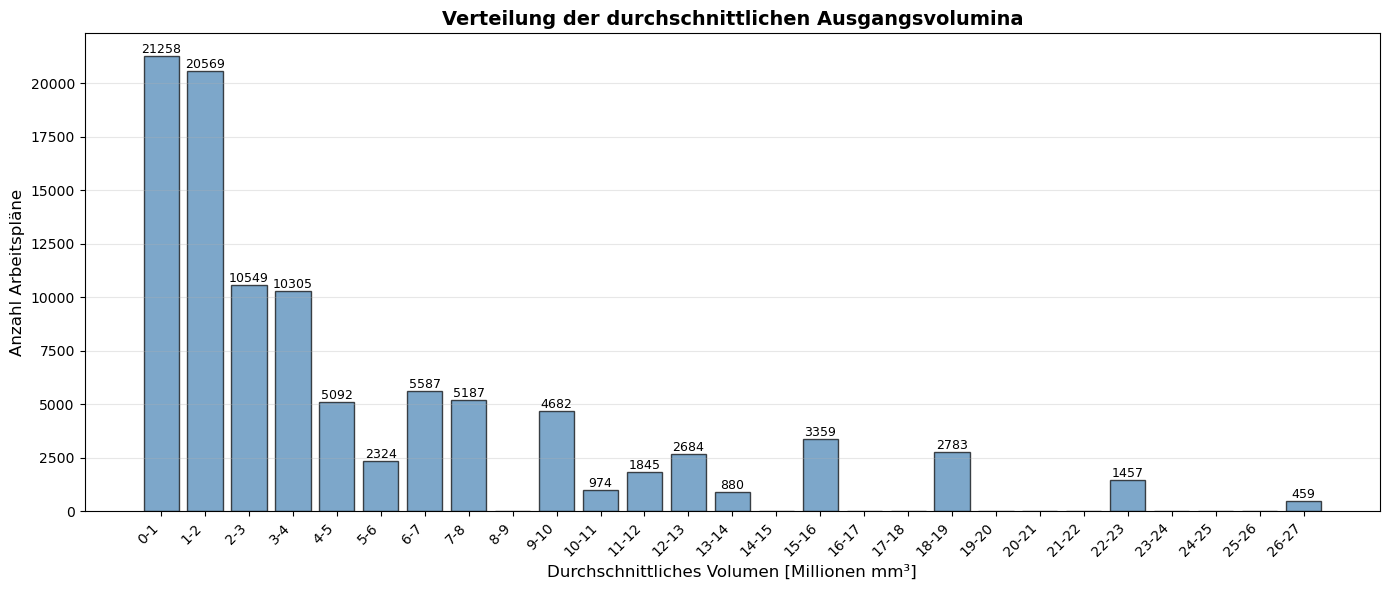

Minimales Volumen: 200000.00 mm³
Maximales Volumen: 27000000.00 mm³


In [27]:
# Verteilung Ausgangsvolumen
bins_volume = np.arange(0, plan_stats_df['Ausgangsvolumen'].max() + 1_000_000, 1_000_000)

counts_vol, bin_edges_vol = np.histogram(plan_stats_df['Ausgangsvolumen'], bins=bins_volume)

bin_labels_vol = [f"{int(bin_edges_vol[i]/1_000_000)}-{int(bin_edges_vol[i+1]/1_000_000)}" 
                  for i in range(len(bin_edges_vol)-1)]

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(bin_labels_vol, counts_vol, edgecolor='black', alpha=0.7, color='steelblue')

for i, (bar, count) in enumerate(zip(bars, counts_vol)):
    if count > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{int(count)}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Durchschnittliches Volumen [Millionen mm³]', fontsize=12)
ax.set_ylabel('Anzahl Arbeitspläne', fontsize=12)
ax.set_title('Verteilung der durchschnittlichen Ausgangsvolumina', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Minimales Volumen: {plan_stats_df['Ausgangsvolumen'].min():.2f} mm³")
print(f"Maximales Volumen: {plan_stats_df['Ausgangsvolumen'].max():.2f} mm³")

Min. Volumendifferenz: -18699486.08 mm³
Max. Volumendifferenz: 23768484.40 mm³
Median: -267873.52 mm³


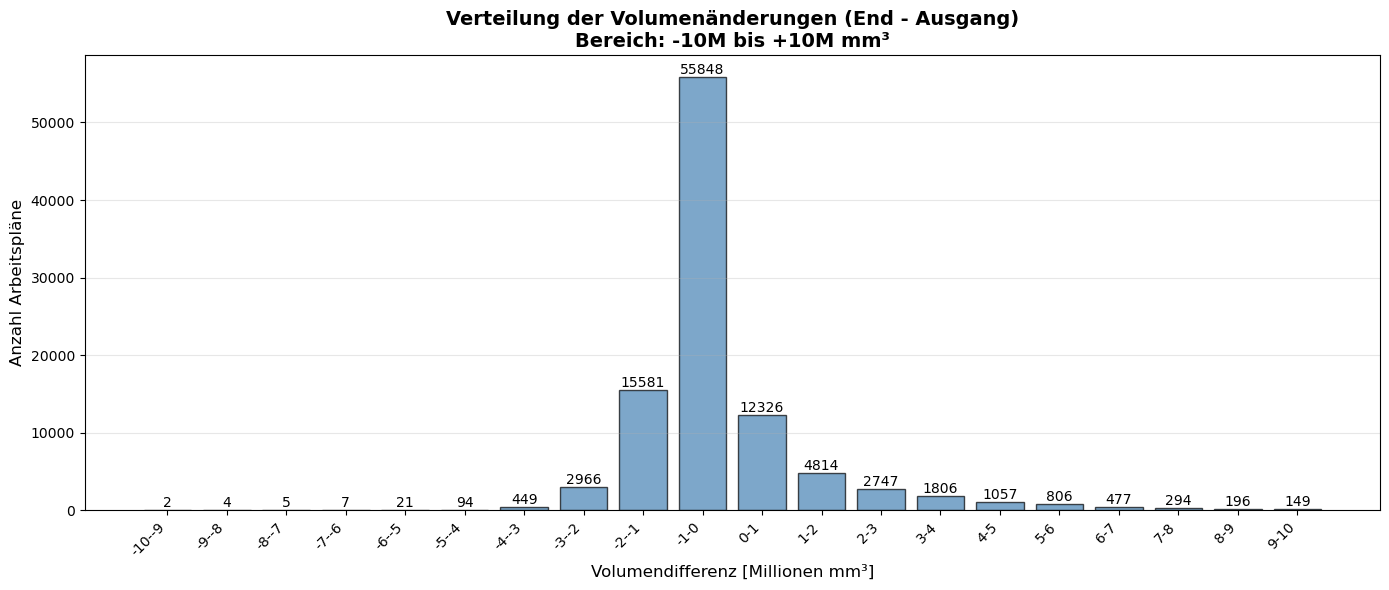


Außerhalb des Bereichs: 345 Pläne (0.35%)


In [28]:
# Volumendifferenz
min_diff = plan_stats_df['Volumendifferenz'].min()
max_diff = plan_stats_df['Volumendifferenz'].max()

print(f"Min. Volumendifferenz: {min_diff:.2f} mm³")
print(f"Max. Volumendifferenz: {max_diff:.2f} mm³")
print(f"Median: {plan_stats_df['Volumendifferenz'].median():.2f} mm³")

focus_min = -10_000_000
focus_max = 10_000_000
bin_size = 1_000_000

bins_diff = np.arange(focus_min, focus_max + bin_size, bin_size)

counts_diff, bin_edges_diff = np.histogram(plan_stats_df['Volumendifferenz'], bins=bins_diff)

bin_labels_diff = [f"{int(bin_edges_diff[i]/1_000_000)}-{int(bin_edges_diff[i+1]/1_000_000)}" 
                   for i in range(len(bin_edges_diff)-1)]

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(bin_labels_diff, counts_diff, edgecolor='black', alpha=0.7, color='steelblue')

for i, (bar, count) in enumerate(zip(bars, counts_diff)):
    if count > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{int(count)}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Volumendifferenz [Millionen mm³]', fontsize=12)
ax.set_ylabel('Anzahl Arbeitspläne', fontsize=12)
ax.set_title('Verteilung der Volumenänderungen (End - Ausgang)\nBereich: -10M bis +10M mm³', 
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

outside = len(plan_stats_df[(plan_stats_df['Volumendifferenz'] < focus_min) | 
                            (plan_stats_df['Volumendifferenz'] > focus_max)])
print(f"\nAußerhalb des Bereichs: {outside} Pläne ({outside/len(plan_stats_df)*100:.2f}%)")

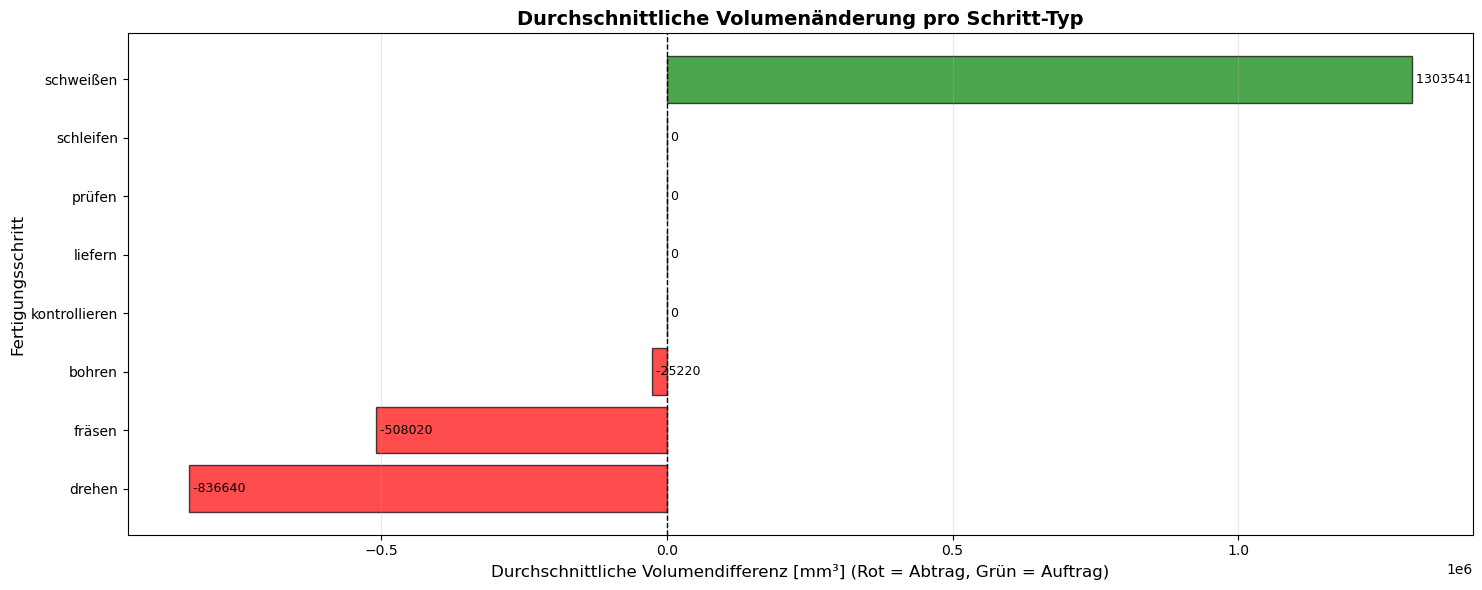


Top 5 Material-Abtrag:
      Schritt  Avg_Volumendifferenz  Anzahl
       drehen        -836640.114794   29345
       fräsen        -508020.442487   62527
       bohren         -25219.584146   69643
kontrollieren              0.000000    8329
      liefern              0.000000   99994

Top 5 Material-Auftrag:
      Schritt  Avg_Volumendifferenz  Anzahl
    schweißen          1.303541e+06   40672
kontrollieren          0.000000e+00    8329
      liefern          0.000000e+00   99994
       prüfen          0.000000e+00   40672
    schleifen          0.000000e+00    8329


In [29]:
# Durchschnittliche Volumendifferenz pro Schritt 
avg_vol_change = step_vol_df.groupby('Schritt')['Volumendifferenz'].agg(['mean', 'count']).reset_index()
avg_vol_change.columns = ['Schritt', 'Avg_Volumendifferenz', 'Anzahl']
avg_vol_change = avg_vol_change.sort_values('Avg_Volumendifferenz')

fig, ax = plt.subplots(figsize=(15, max(6, len(avg_vol_change) * 0.4)))

colors = ['red' if x < 0 else 'green' for x in avg_vol_change['Avg_Volumendifferenz']]
bars = ax.barh(avg_vol_change['Schritt'], avg_vol_change['Avg_Volumendifferenz'], 
               color=colors, alpha=0.7, edgecolor='black')

for i, (schritt, vol_diff) in enumerate(zip(avg_vol_change['Schritt'], avg_vol_change['Avg_Volumendifferenz'])):
    ax.text(vol_diff, i, f' {vol_diff:.0f}', va='center', fontsize=9)

ax.set_xlabel('Durchschnittliche Volumendifferenz [mm³] (Rot = Abtrag, Grün = Auftrag)', fontsize=12)
ax.set_ylabel('Fertigungsschritt', fontsize=12)
ax.set_title('Durchschnittliche Volumenänderung pro Schritt-Typ', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 Material-Abtrag:")
print(avg_vol_change.nsmallest(5, 'Avg_Volumendifferenz')[['Schritt', 'Avg_Volumendifferenz', 'Anzahl']].to_string(index=False))

print("\nTop 5 Material-Auftrag:")
print(avg_vol_change.nlargest(5, 'Avg_Volumendifferenz')[['Schritt', 'Avg_Volumendifferenz', 'Anzahl']].to_string(index=False))

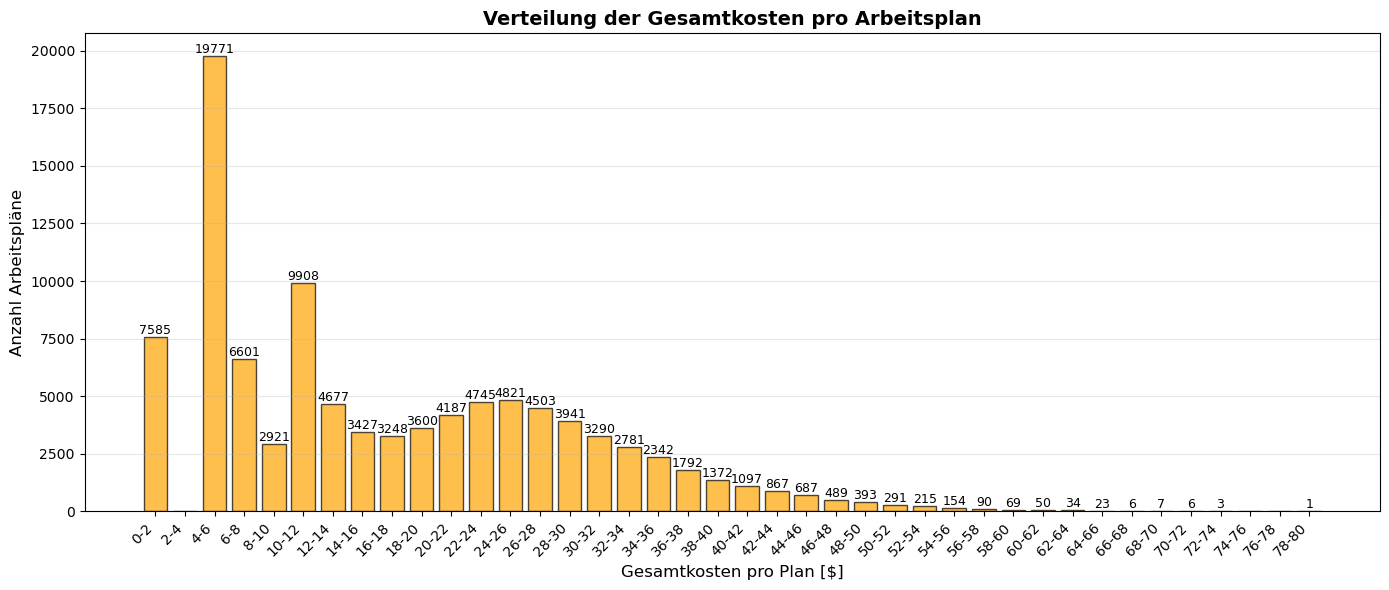

In [30]:
# Gesamtkosten
bin_size = 2
bins_cost = np.arange(0, plan_costs_df['Gesamtkosten'].max() + bin_size, bin_size)

counts_cost, bin_edges_cost = np.histogram(plan_costs_df['Gesamtkosten'], bins=bins_cost)

bin_labels_cost = [f"{int(bin_edges_cost[i])}-{int(bin_edges_cost[i+1])}" 
                   for i in range(len(bin_edges_cost)-1)]

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(bin_labels_cost, counts_cost, edgecolor='black', alpha=0.7, color='orange')

for i, (bar, count) in enumerate(zip(bars, counts_cost)):
    if count > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{int(count)}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Gesamtkosten pro Plan [$]', fontsize=12)
ax.set_ylabel('Anzahl Arbeitspläne', fontsize=12)
ax.set_title('Verteilung der Gesamtkosten pro Arbeitsplan', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

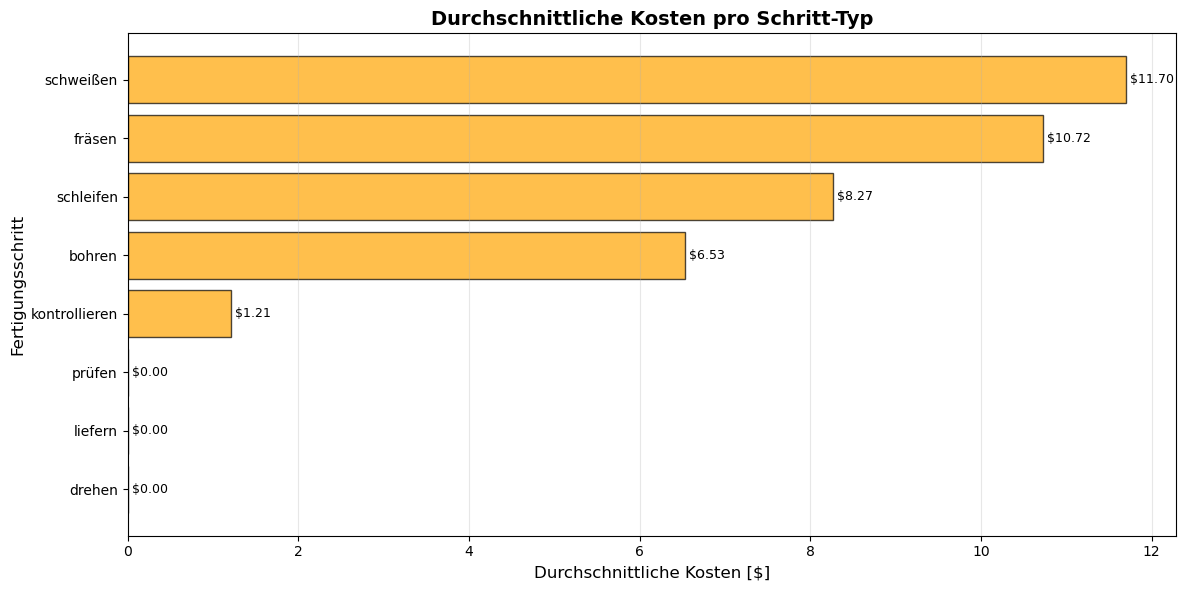

In [31]:
#Durchschnittliche Kosten pro Schritt
avg_costs = step_costs_df.groupby('Schritt')['Kosten'].agg(['mean', 'count']).reset_index()
avg_costs.columns = ['Schritt', 'Avg_Kosten', 'Anzahl']
avg_costs = avg_costs.sort_values('Avg_Kosten', ascending=True)

fig, ax = plt.subplots(figsize=(12, max(6, len(avg_costs) * 0.3)))

bars = ax.barh(avg_costs['Schritt'], avg_costs['Avg_Kosten'], 
               color='orange', alpha=0.7, edgecolor='black')

for i, (schritt, cost) in enumerate(zip(avg_costs['Schritt'], avg_costs['Avg_Kosten'])):
    ax.text(cost, i, f' ${cost:.2f}', va='center', fontsize=9)

ax.set_xlabel('Durchschnittliche Kosten [$]', fontsize=12)
ax.set_ylabel('Fertigungsschritt', fontsize=12)
ax.set_title('Durchschnittliche Kosten pro Schritt-Typ', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

